In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

#visits = [181898, 182014, 193861, 219976, 405724, 417009, 417057, 436500, 452564, 452599, 456722]
#visits = [230, 192896, 204387, 211950, 214315, 216748, 225457]
visits = [1170860, 1183959, 1208209, 1215970, 1218145, 1230369]
filt = 'i'

bigCat = Table.read('src_catalog_2.fits')

In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt


visits = [1170860, 1183959, 1208209, 1215970, 1218145, 1230369]
#visits = [230, 192896, 204387, 211950, 214315, 216748, 225457]
#visits = [219976, 405724]
#tracts = [4429,  4431,  4433,  4637,  4639,  4848,  4850,  4852,  5063,  5065,
#          4430,  4432,  4636,  4638,  4640,  4849,  4851,  5062,  5064,  5066]

#Fix the track number for the moment
tract = 4848
filt = 'i'
butler = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/imsim/input/rerun/test-jointcal")

#fluxType = "base_PsfFlux"
fluxType = "slot_ModelFlux"
#fluxType = "base_CircularApertureFlux_6_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]

In [6]:
catList = []
for visit in visits:
    print('Reading visit:', visit)
    for count,data_ref in enumerate(butler.subset('src', visit=visit)):
        if data_ref.datasetExists():
            dataId = data_ref.dataId
        else:
            continue
        dataId['tract'] = tract
        if butler.datasetExists('jointcal_wcs', dataId) == False:
            continue
        if count%10 == 0 :
            print(count, dataId)
        src = butler.get('src', dataId, immediate=True, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
        v = src.asAstropy()
        
        # Get new photometry calibration
        newPhotocal = butler.get('jointcal_photoCalib', dataId, immediate=True)
        newMag = newPhotocal.instFluxToMagnitude(src, fluxType)
        v['newMag'] = newMag[:,0]
        v['newMagErr'] = newMag[:,1]

        # select sources
        cut = np.ones_like(v['id'], dtype=bool)
        for flag in Flags:
            cut &= v[flag]==False
        cut &= (v[fluxType + '_instFlux'] > 0) & (v[fluxType + '_instFlux'] / v[fluxType + '_instFluxErr'] > 5)
        cut &= v['base_ClassificationExtendedness_value'] < 0.5

        # get calibration object and then magnitudes with errors
        calib = butler.get("calexp_calib", dataId, immediate=True)
        mag, magErr = calib.getMagnitude(v[cut][fluxType + '_instFlux'], v[cut][fluxType + '_instFluxErr'])

        cat = v[cut]['id', 'coord_ra', 'coord_dec', fluxType + '_instFlux', 'newMag', 'newMagErr']
        cat['mag'] = mag
        cat['magErr'] = magErr

        # add dataId info
        for k in dataId.keys():
            cat[k] = dataId[k]
            
        # Get WCS info from calexp_wcs and from jointcal_wcs
        oldWcs = butler.get("calexp_wcs", dataId, immediate=True)
        newWcs = butler.get('jointcal_wcs', dataId, immediate=True)
        
        newRa = []
        newDec = []
        pixels = oldWcs.skyToPixel([afwGeom.SpherePoint(ra, dec, afwGeom.radians) for ra, dec in zip(cat['coord_ra'], cat['coord_dec'])])
        newCoord = newWcs.pixelToSky(pixels)                                       
#        for c in cat:
#            pixels = oldWcs.skyToPixel(afwGeom.SpherePoint(c['coord_ra'], c['coord_dec'], afwGeom.radians))
#            newRa.append(float((newWcs.pixelToSky(pixels).getRa())))
#            newDec.append(float((newWcs.pixelToSky(pixels).getDec())))
        cat['newRa'] = [float(cd.getRa()) for cd in newCoord]
        cat['newDec'] = [float(cd.getDec()) for cd in newCoord]
        cat['newRa'].unit = units.rad
        cat['newDec'].unit = units.rad

        # hack to get rid of a warning related to a merging conflict
        cat.meta['NOISE_EXPOSURE_ID'] = 0
         
        # add catalog to the list    
        catList.append(cat)
        
# merge all individual catalogs into a single big one    
bigCat = vstack(catList)


Reading visit: 1170860
0 {'visit': 1170860, 'filter': 'i', 'raftName': 'R01', 'detectorName': 'S00', 'detector': 0, 'tract': 4848}


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2018_39/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


10 {'visit': 1170860, 'filter': 'i', 'raftName': 'R02', 'detectorName': 'S01', 'detector': 10, 'tract': 4848}
20 {'visit': 1170860, 'filter': 'i', 'raftName': 'R03', 'detectorName': 'S20', 'detector': 24, 'tract': 4848}
30 {'visit': 1170860, 'filter': 'i', 'raftName': 'R11', 'detectorName': 'S00', 'detector': 36, 'tract': 4848}
40 {'visit': 1170860, 'filter': 'i', 'raftName': 'R12', 'detectorName': 'S01', 'detector': 46, 'tract': 4848}
50 {'visit': 1170860, 'filter': 'i', 'raftName': 'R13', 'detectorName': 'S10', 'detector': 57, 'tract': 4848}
60 {'visit': 1170860, 'filter': 'i', 'raftName': 'R20', 'detectorName': 'S20', 'detector': 78, 'tract': 4848}
70 {'visit': 1170860, 'filter': 'i', 'raftName': 'R21', 'detectorName': 'S21', 'detector': 88, 'tract': 4848}
80 {'visit': 1170860, 'filter': 'i', 'raftName': 'R22', 'detectorName': 'S22', 'detector': 98, 'tract': 4848}
Reading visit: 1183959
0 {'visit': 1183959, 'filter': 'i', 'raftName': 'R01', 'detectorName': 'S20', 'detector': 6, 'tra

In [ ]:
bigCat.write('src_catalog_2.fits')

In [7]:
bigCat

id,coord_ra,coord_dec,slot_ModelFlux_instFlux,newMag,newMagErr,mag,magErr,visit,filter,raftName,detectorName,detector,tract,newRa,newDec
,rad,rad,ct,,,,,,,,,,,rad,rad
int64,float64,float64,float64,float64,float64,float64,float64,int64,str1,str3,str3,int64,int64,float64,float64
1005761081638912008,0.939494366341625,-0.5109472370684955,1732.4448030682029,22.779533651242645,0.10913097983915246,22.78511670626021,0.10913098869413194,1170860,i,R01,S00,0,4848,0.9394944687103278,-0.5109473340215515
1005761081638912009,0.939209782870031,-0.5109091721712858,6184.934743800997,21.397923803849203,0.03398708385723958,21.40342741813359,0.033987111887643334,1170860,i,R01,S00,0,4848,0.939209870747724,-0.5109092596497484
1005761081638912010,0.9402330768116518,-0.5110311016795787,1664.3452659754907,22.822794871036372,0.10281251960408153,22.828656660058325,0.10281252946997874,1170860,i,R01,S00,0,4848,0.9402332066480923,-0.5110312392559021
1005761081638912016,0.940177035986216,-0.5110000032047376,1444.8199846184725,22.976250602317812,0.13146813375752348,22.982230872356286,0.1314681416280793,1170860,i,R01,S00,0,4848,0.9401771579814852,-0.5110001328099127
1005761081638912023,0.9369755539989394,-0.5105819377253946,11274.600039732504,20.74652696936489,0.01912357194853487,20.751512361527706,0.01912361709587838,1170860,i,R01,S00,0,4848,0.9369755328195851,-0.510581968370089
1005761081638912026,0.9389236275791268,-0.510810474904593,841.470242132915,23.563423122373823,0.20427047275650695,23.569168317351053,0.20427047762391945,1170860,i,R01,S00,0,4848,0.9389236879289293,-0.510810548516476
1005761081638912031,0.9367831502908932,-0.5105300802056124,28634.163355232915,19.734496121454605,0.009438753354103397,19.739553977088416,0.009438846148791737,1170860,i,R01,S00,0,4848,0.9367831211636788,-0.5105300982822256
1005761081638912032,0.940055697828764,-0.5109122000625772,376487.2750949526,16.936052877781258,0.002072725118700264,16.942389467557646,0.002073253833365425,1170860,i,R01,S00,0,4848,0.9400557987295934,-0.5109123107896806


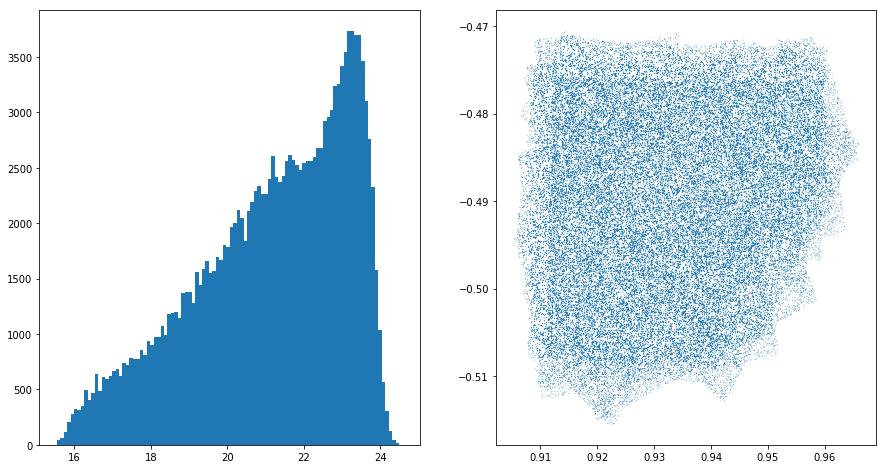

In [8]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(bigCat['mag'], bins=100)
_ = ax1.scatter(bigCat['coord_ra'], bigCat['coord_dec'], s=0.01)

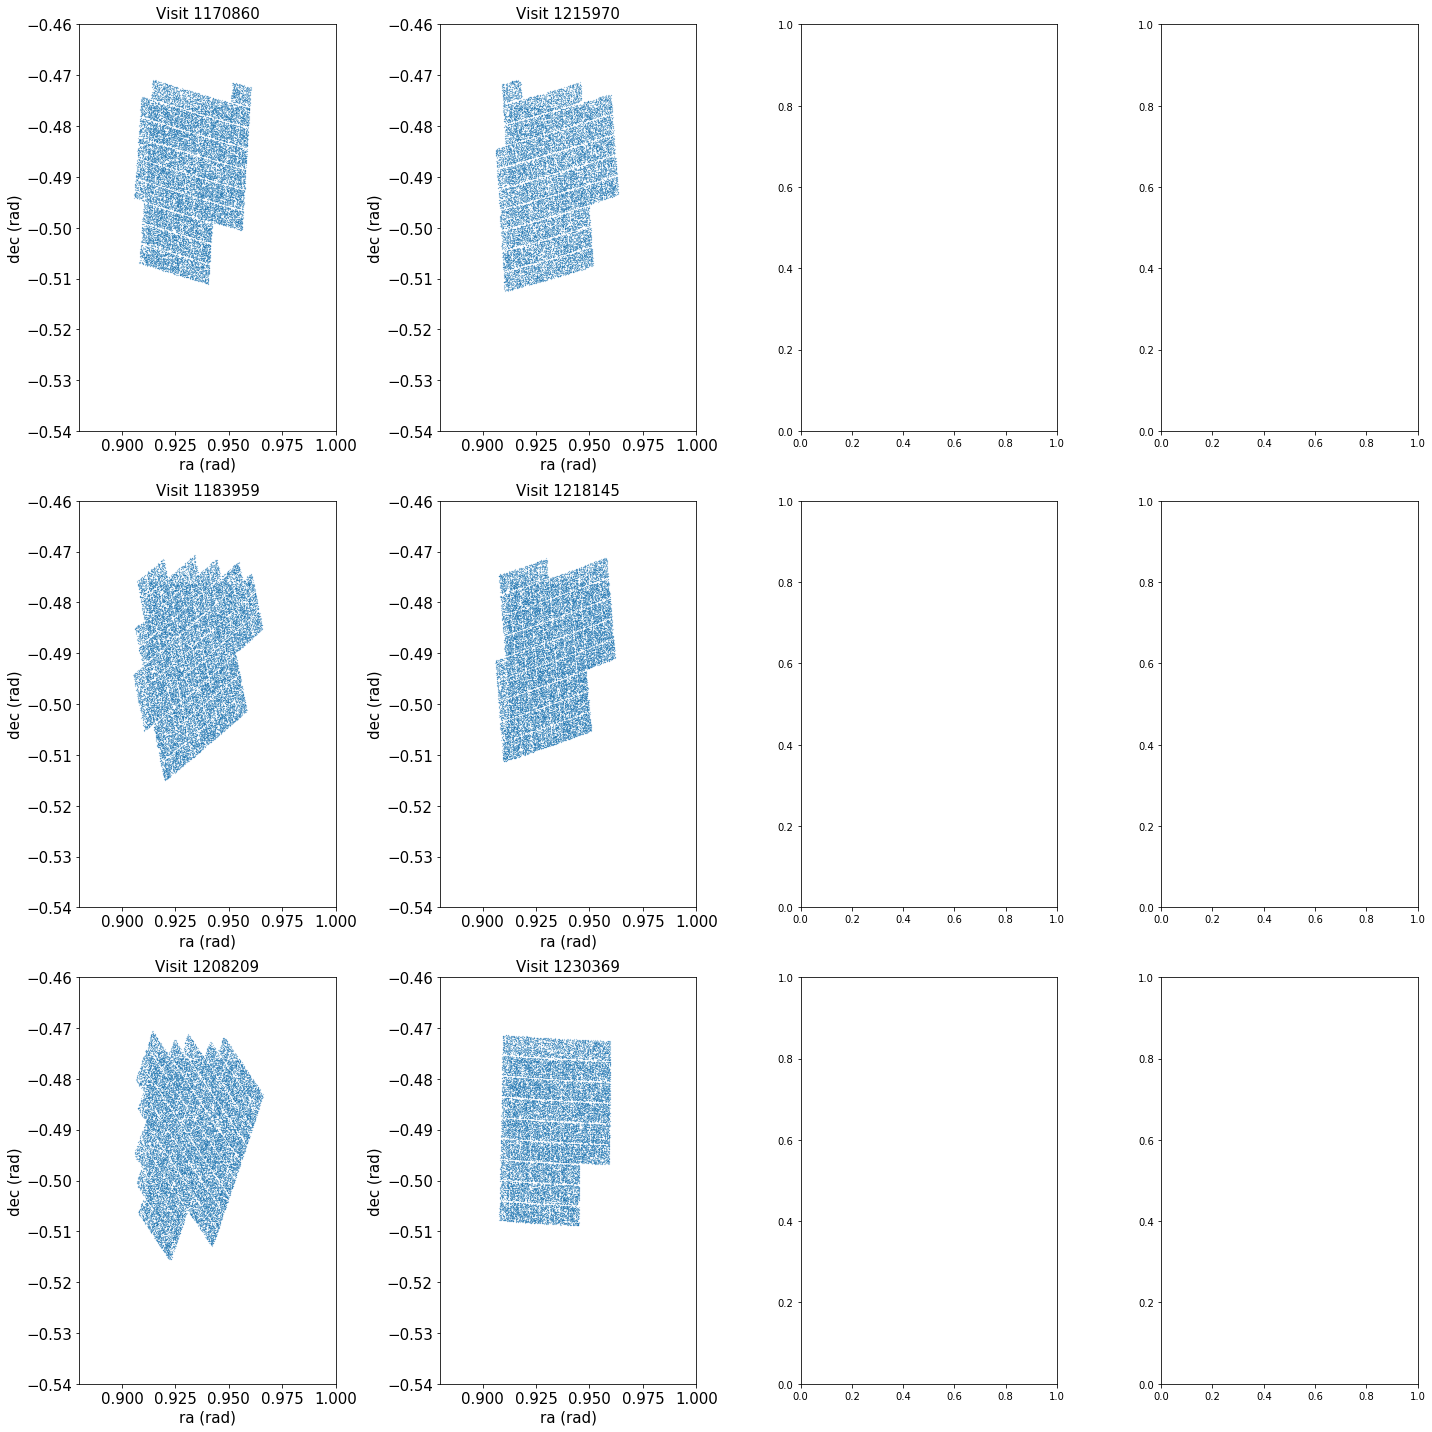

In [9]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,20))
for i,v in enumerate(visits):
    a = i%3
    b = i//3
    cut = bigCat['visit'] == v
    ax[a][b].scatter(bigCat[cut]['coord_ra'], bigCat[cut]['coord_dec'], s=0.02)
    ax[a][b].set_xlim([0.88,1.00])
    ax[a][b].set_ylim([-0.54, -0.46])
    ax[a][b].set_xlabel('ra (rad)', fontsize=15)
    ax[a][b].set_ylabel('dec (rad)', fontsize=15)
    ax[a][b].set_title('Visit %d'%(v), fontsize=15)
    ax[a][b].tick_params(labelsize=15)
    
fig.tight_layout()

In [42]:
#fig.savefig("ra_dec_r.png")

In [11]:
from astropy.coordinates import SkyCoord
from astropy import units as u

visits = [1170860, 1183959, 1208209, 1215970, 1218145, 1230369]
vRef = 1170860
tract = 4848
cRef = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['coord_ra'], dec = bigCat[bigCat['visit']==vRef]['coord_dec'])
cRefNew = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['newRa'], dec = bigCat[bigCat['visit']==vRef]['newDec'])

bigCat['dist'] = 999999.

dist = []
distNew = []
dMag = []
dMagNew = []
for count,v in enumerate(visits):
    if v == vRef:
        dist = dist + [9999.]*sum(bigCat['visit']==vRef)
        distNew = distNew + [9999.]*sum(bigCat['visit']==vRef)
        dMag = dMag + [9999.]*sum(bigCat['visit']==vRef)
        dMagNew = dMagNew + [9999.]*sum(bigCat['visit']==vRef)
        continue
    
    c = SkyCoord(ra = bigCat[bigCat['visit']==v]['coord_ra'], dec = bigCat[bigCat['visit']==v]['coord_dec'])
    cNew = SkyCoord(ra = bigCat[bigCat['visit']==v]['newRa'], dec = bigCat[bigCat['visit']==v]['newDec'])
    idx, d2d, d3d = c.match_to_catalog_sky(cRef)
    idxNew, d2dNew, d3dNew = cNew.match_to_catalog_sky(cRefNew)
    
    dist = dist + d2d.milliarcsecond.tolist()
    distNew = distNew + d2dNew.milliarcsecond.tolist()
    
    dMag = dMag + (bigCat[bigCat['visit']==v]['mag'] - bigCat[bigCat['visit']==vRef]['mag'][idx]).tolist()
    dMagNew = dMagNew + (bigCat[bigCat['visit']==v]['newMag'] - bigCat[bigCat['visit']==vRef]['newMag'][idxNew]).tolist()
    
bigCat['dist'] = dist
bigCat['distNew'] = distNew
bigCat['dMag'] = dMag
bigCat['dMagNew'] = dMagNew

In [ ]:
 bigCat[bigCat['visit']==v]['mag']  - bigCat[bigCat['visit']==vRef]['mag'][idx]

In [ ]:
dMag

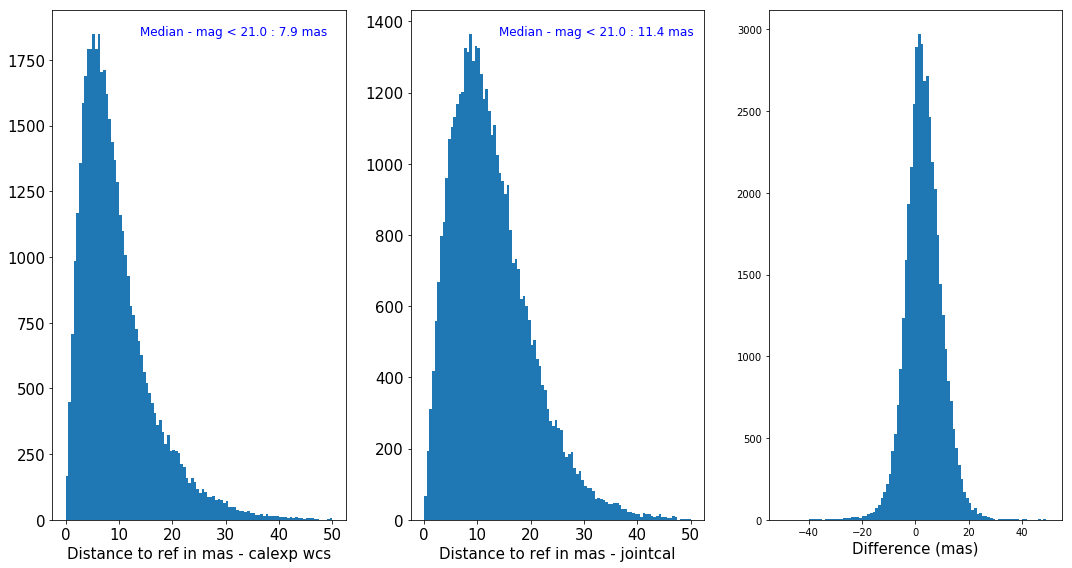

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))

magCut = 21
cut = (bigCat['dist'] < 300) & (bigCat['distNew'] < 300) & (bigCat['mag'] < magCut)
_ = ax0.hist(bigCat[cut]['dist'], bins=100, range = [0., 50])
_ = ax1.hist(bigCat[cut]['distNew'], bins=100, range = [0., 50])
_ = ax2.hist(bigCat[cut]['distNew'] - bigCat[cut]['dist'], bins=100, range=[-50, 50])

ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax0.set_xlabel('Distance to ref in mas - calexp wcs', fontsize=15)
ax1.set_xlabel('Distance to ref in mas - jointcal', fontsize=15)
ax2.set_xlabel('Difference (mas)', fontsize=15)

ax0.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['dist'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
ax1.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['distNew'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
                                                         
fig.tight_layout()

In [8]:
fig.savefig("DC2_astrometry.png")

0.012610129903833922 -0.40306667712641797
20.18083419360998 20.213158547126884


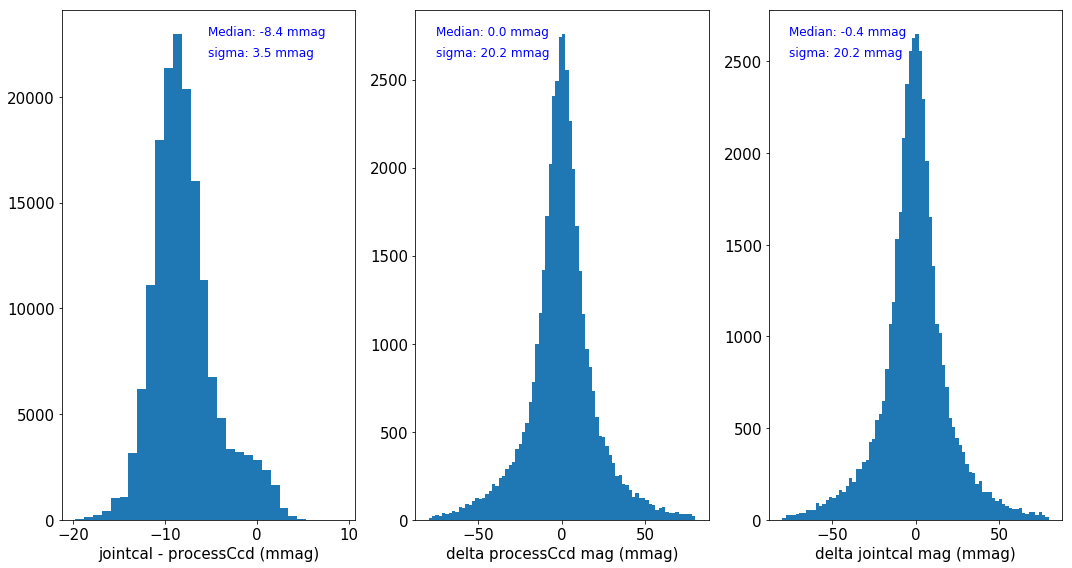

In [13]:
magCut = 21
cut = (bigCat['dMag'] < 0.08) & (bigCat['dMagNew'] < 0.08) & (bigCat['mag'] < magCut) & (bigCat['dMag'] > -0.08) & (bigCat['dMagNew'] > -0.08)
cut &= (bigCat['distNew'] < 50)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))
_ = ax0.hist((bigCat['newMag'] - bigCat['mag'])*1000, bins=30)
_ = ax1.hist(bigCat[cut]['dMag']*1000, bins=80)
_ = ax2.hist(bigCat[cut]['dMagNew']*1000, bins=80)

ax0.set_xlabel('jointcal - processCcd (mmag)', fontsize=15)
ax1.set_xlabel('delta processCcd mag (mmag)', fontsize=15)
ax2.set_xlabel('delta jointcal mag (mmag)', fontsize=15)

ax0.annotate("Median: %0.1f mmag"%(np.median(bigCat['newMag'] - bigCat['mag'])*1000),
             fontsize=12, color='b', xy=(0.5, 0.95), xycoords='axes fraction')
ax0.annotate("sigma: %0.1f mmag"%(np.std(bigCat['newMag'] - bigCat['mag'])*1000),
             fontsize=12, color='b', xy=(0.5, 0.91), xycoords='axes fraction')
ax1.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax1.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')
ax2.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax2.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')


ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

fig.tight_layout()

print(np.median(bigCat[cut]['dMag']*1000), np.median(bigCat[cut]['dMagNew']*1000))
print(np.std(bigCat[cut]['dMag']*1000), np.std(bigCat[cut]['dMagNew']*1000))

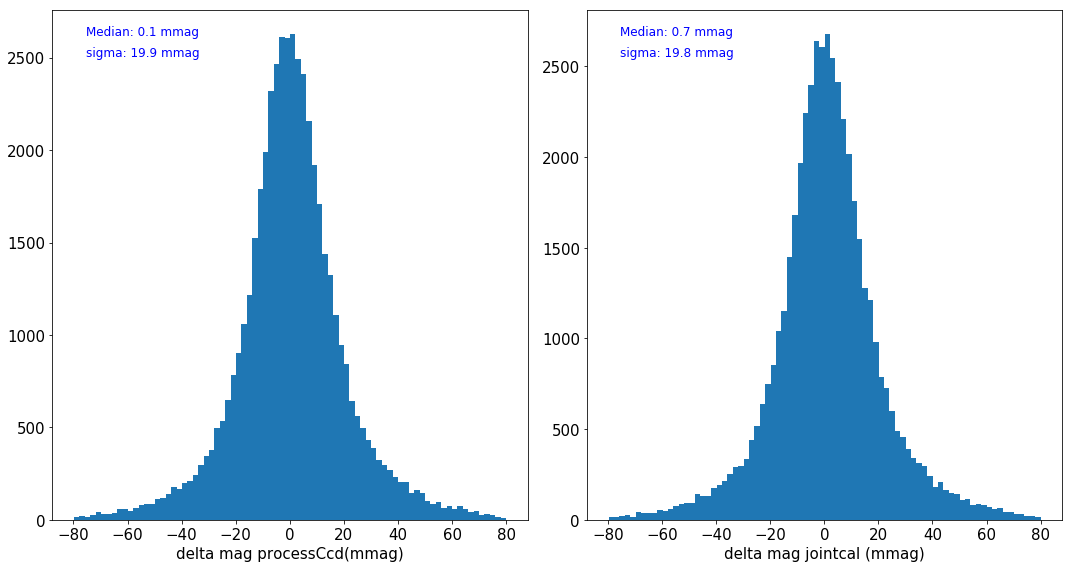

In [9]:
magCut = 21
cut = (bigCat['dMag'] < 0.08) & (bigCat['dMagNew'] < 0.08) & (bigCat['mag'] < magCut) & (bigCat['dMag'] > -0.08) & (bigCat['dMagNew'] > -0.08)
cut &= (bigCat['distNew'] < 50)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax1.hist(bigCat[cut]['dMag']*1000, bins=80)
_ = ax2.hist(bigCat[cut]['dMagNew']*1000, bins=80)

ax1.set_xlabel('delta mag processCcd(mmag)', fontsize=15)
ax2.set_xlabel('delta mag jointcal (mmag)', fontsize=15)

ax1.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax1.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')
ax2.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax2.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')


ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

fig.tight_layout()

In [25]:
fig.savefig("DC2_photometry_constrained.png")

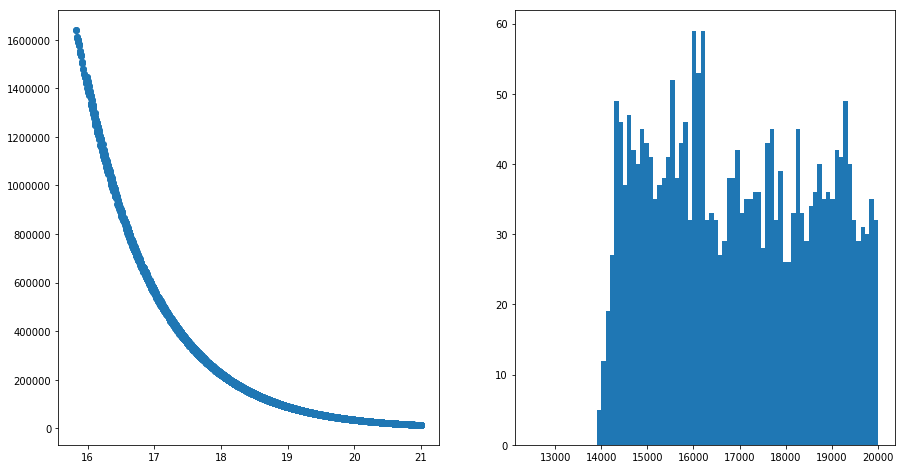

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax1.scatter(bigCat[cut]['mag'], bigCat[cut]['slot_ModelFlux_flux'])
_ = ax2.hist(bigCat[cut]['slot_ModelFlux_flux'], bins=80, range=[12500, 20000])

In [12]:
def getValidDataIds(butler, tract, dataset_type='jointcal_photoCalib'):
    """Return a list of all dataIds that exist in this butler.

    This exists here because the butler doesn't provide this functionality.

    Parameters
    ----------
    butler : `lsst.daf.persistence.Butler`
        The butler to search within.
    tract : `int`
        Tract id to include in search.
    dataset_type : `str`
        Dataset type to search for.
    """
    data_ids = []
    for data_ref in butler.subset(dataset_type, tract=tract):
        if data_ref.datasetExists():
            data_ids.append(data_ref.dataId)
    return data_ids

In [13]:
dataIds = getValidDataIds(butler, 5063)

In [14]:
dataIds

[{'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R12',
  'detectorName': 'S22'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S02'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S11'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S12'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S20'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S21'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S22'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R14',
  'detectorName': 'S00'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R14',
  'detectorName': 'S01'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R14',
  'detectorName': 'S02'},
 {'tract': 5063,
  'filter': '